# Desafio Properati

## 1) Importación de librerías

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.formula.api as smf
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium
import geopandas as gdp

%matplotlib inline

#### Importamos los datos y generamos el dataframe

In [2]:
df = pd.read_csv("properatti.csv")
df.head(6)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...
5,5,sell,house,Gualeguaychú,|Argentina|Entre Ríos|Gualeguaychú|,Argentina,Entre Ríos,3433657.0,"-33.0140714,-58.519828",-33.014071,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bop_venta_depart...,"Casa en el perímetro del barrio 338, ubicada e...","Casa Barrio 338. Sobre calle 3 de caballería, ...",https://thumbs4.properati.com/6/q-w68gvaUEQVXI...


#### Obtenemos los porcentajes de datos faltantes de cada variable

In [104]:
for cols in df.columns:
    nulos = df[cols].isnull().sum()
    porcentaje = nulos/len(df)
    print(f'{porcentaje*100:.0f}%', cols)

0% operation
0% property_type
0% place_name
0% country_name
0% state_name
15% geonames_id
17% price
17% currency
17% price_aprox_local_currency
17% price_aprox_usd
32% surface_total_in_m2
16% surface_covered_in_m2
43% price_usd_per_m2
28% price_per_m2
93% floor
54% rooms
88% expenses
0% properati_url
0% description
0% title
3% image_thumbnail
0% pais
0% provincia
0% localidad
67% barrio
43% lat
43% lon
82% amb_tit
94% dor_tit
99% bath_tit
69% amb_desc
67% dor_desc
91% bath_desc
99% pozo
17% log_price
17% log_price_aprox_usd
43% log_price_usd_per_m2


Con respecto a los datos faltantes, rápidamente podemos descartar variables que son innecesarias, tales como:
`properati_url`, `Unnamed:0`, `lat` y `lon`. Estas últmas  2, no son necesarias ya que contamos con `lat-lon` que tiene mayor precisión.

Por otra parte, existen demasiados datos faltantes de las variables `floor` y `expenses`, por lo que sería conveniente descartarlas por completo. 

En cuanto a una las variables críticas del modelo, vemos que `rooms` tiene un 61% de datos faltantes, lo que requiere dedicación para extraer datos de los títulos y descripciones. También es alarmante que no existan datos de **baños**, **dormitorios**, **amenities** o de **cocheras**, por lo que sería conveniente al menos intentar extraer datos relacionados.

Finalmente, las variables relacionadas a las coordenadas geográficas tienen datos sobre el 57% de la muestra y lamentablemente no es factible intentar extraerla ya que no es información que se pueda conseguir en las descripciones. Afortunadamente contamos con información de los barrios y localidades en la variable `place_with_parent_names`, lo que nos permite generar dummies y calcular matrices de ponderación espacial por contigüidad.


### Desagregamos los datos contenidos en `place_with_parent_names`

In [4]:
place_split = df.place_with_parent_names.str.split('|', expand=True).rename({1:'pais', 2:'provincia',
                                                               3:'localidad', 4:'barrio'}, axis=1).drop([0,5,6], axis=1)

place_split.loc[(place_split.barrio == ''), 'barrio'] = np.nan

#### Los adjuntamos al df original

In [5]:
df = df.join(place_split)
df

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,rooms,expenses,properati_url,description,title,image_thumbnail,pais,provincia,localidad,barrio
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,Argentina,Capital Federal,Mataderos,NaN
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,NaN
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,Argentina,Capital Federal,Mataderos,NaN
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,Argentina,Capital Federal,Liniers,NaN
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121215,121215,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,NaN,NaN,...,NaN,10000.0,http://www.properati.com.ar/1cja2_venta_depart...,TORRE FORUM ALCORTA - MÁXIMA CATEGORÍA.Impecab...,Torre Forum Alcorta- Impecable 3 ambientes,https://thumbs4.properati.com/1/bjms0KnaAnlNoQ...,Argentina,Capital Federal,Belgrano,NaN
121216,121216,sell,house,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3436080.0,NaN,NaN,...,NaN,NaN,http://www.properati.com.ar/1cja6_venta_casa_b...,Excelente e impecable casa en Venta en Las Lom...,Ruca Inmuebles | Venta | Lomas de San Isidro |...,https://thumbs4.properati.com/2/PCc3WuQDjpNZc4...,Argentina,Bs.As. G.B.A. Zona Norte,San Isidro,Beccar
121217,121217,sell,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,3433775.0,"-34.5706388726,-58.4755963355",-34.570639,...,NaN,NaN,http://www.properati.com.ar/1cja7_venta_depart...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,https://thumbs4.properati.com/9/YAe_-2gRVykADP...,Argentina,Capital Federal,Villa Urquiza,NaN
121218,121218,sell,apartment,Plaza Colón,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,NaN,NaN,NaN,...,NaN,NaN,http://www.properati.com.ar/1cja8_venta_depart...,"2 Amb al contrafrente, luminoso. El departame...",2 amb. C/ dep. de servicio al contrafrente| Re...,https://thumbs4.properati.com/8/Q12PTvU6BQJ0ib...,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Plaza Colón


#### Eliminamos las columnas ahora innecesarias

In [6]:
df.drop(["place_with_parent_names", "Unnamed: 0"], axis=1, inplace=True)

#### Separamos las coordenadas albergadas en la variable `lat-lon` que aparentemente tienen mayor precisión que las que se ofrecen en las variables `lat` y `lon`

Posteriormente, eliminamos las variables redundantes del df original y adjuntamos las nuevas en formato `float`

In [7]:
lat_lon = df['lat-lon'].str.split(',', expand=True)
lat_lon = lat_lon.rename({0:'lat', 1:'lon'}, axis=1)
df = df.drop(['lat-lon', 'lat', 'lon'], axis=1).join(lat_lon)

In [8]:
df['lat'] = df.lat.astype(np.float)
df['lon'] = df.lon.astype(np.float)

#### Generamos expresiones regulares para extraer datos de las descripciones y títulos.
Empezamos por los patrones de referentes a ambientes y dormitorios con una expresión bastante sencilla

In [9]:
pat_ambientes = r'\b(\d{1,2})\s*amb'
pat_dormitorios = r'\b(\d{1,2})\s*dor'
pat_banos = r'\b(\d{1,2})\s*bañ'

#### Extraemos los datos a las nuevas columnas `amb_tit`, `dor_tit`, `amb_desc` y `dor_desc`

In [10]:
# primero del titulo
df['amb_tit'] = df.title.str.extract(pat_ambientes, re.IGNORECASE, expand=True).astype(np.float)
df['dor_tit'] = df.title.str.extract(pat_dormitorios, re.IGNORECASE, expand=True).astype(np.float)
df['bath_tit'] = df.title.str.extract(pat_banos, re.IGNORECASE, expand=True).astype(np.float)

#luegp de la descripcion
df['amb_desc'] = df.description.str.extract(pat_ambientes, re.IGNORECASE, expand=True).astype(np.float)
df['dor_desc'] = df.description.str.extract(pat_dormitorios, re.IGNORECASE, expand=True).astype(np.float)
df['bath_desc'] = df.description.str.extract(pat_banos, re.IGNORECASE, expand=True).astype(np.float)

Verificamos los valores extraídos

In [11]:
df.loc[~(df.amb_tit.isnull())].filter(['amb_tit']).sort_values('amb_tit').amb_tit.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14.,
       15.])

In [12]:
df.loc[~(df.dor_tit.isnull())].filter(['dor_tit']).sort_values('dor_tit').dor_tit.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 10.])

In [107]:
df.loc[~(df.bath_tit.isnull())].filter(['bath_tit']).sort_values('bath_tit').bath_tit.unique()

array([1., 2., 3., 4., 5., 6.])

In [14]:
df.loc[~(df.amb_desc.isnull())].filter(['amb_desc']).sort_values('amb_desc').amb_desc.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       14., 16., 17., 18., 20., 22., 23., 24., 25., 28., 32., 36., 37.,
       50., 53., 65., 70., 75., 84., 90.])

In [15]:
df.loc[~(df.dor_desc.isnull())].filter(['dor_desc']).sort_values('dor_desc').dor_desc.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
       14., 15., 18., 20., 22., 24., 25., 27., 30., 31., 32., 33., 34.,
       35., 40., 41., 42., 43., 44., 45., 48., 50., 51., 52., 53., 54.,
       57., 60., 62., 65., 70., 72., 74., 75., 76., 77., 78., 80., 83.,
       84., 85., 87., 90., 93., 95.])

In [16]:
df.loc[~(df.bath_desc.isnull())].filter(['bath_desc']).sort_values('bath_desc').bath_desc.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       15., 16., 18., 20., 22., 23., 25., 27., 30., 31., 36., 37., 40.,
       41., 42., 43., 48., 50., 51., 52., 55., 60., 61., 64., 65., 70.,
       71., 75., 76., 80., 82., 85., 86., 90., 93., 95.])

Como podemos ver, cuando extraemos datos de la descripción, tenemos mezclados la cantidad de ambientes y los metros de algún ambiente, por lo cual no los consideraremos.

#### Revisamos cuántos valores conseguimos de las distintas fuentes

In [19]:
# primero de los títulos
df.loc[~(df.amb_tit.isnull())].title.count(), df.loc[~(df.dor_tit.isnull())].title.count(), df.loc[~(df.bath_tit.isnull())].title.count()

(21799, 7764, 634)

In [20]:
# luego de las descripciones
df.loc[~(df.amb_desc.isnull())].title.count(), df.loc[~(df.dor_desc.isnull())].title.count(), df.loc[~(df.bath_desc.isnull())].title.count()

(37438, 40448, 11331)

Revisamos cuántas observaciones no poseen datos de precio, ambientes y dormitorios

In [21]:
df.loc[(df.amb_tit.isnull()) & (df.amb_desc.isnull()) & (df.rooms.isnull()) &(df.dor_desc.isnull()) & (df.dor_tit.isnull()) & (df.price.isnull())]

,operation,property_type,place_name,country_name,state_name,geonames_id,price,currency,price_aprox_local_currency,price_aprox_usd,...,localidad,barrio,lat,lon,amb_tit,dor_tit,bath_tit,amb_desc,dor_desc,bath_desc
5,sell,house,Gualeguaychú,Argentina,Entre Ríos,3433657.0,NaN,NaN,NaN,NaN,...,Gualeguaychú,NaN,-33.014071,-58.519828,NaN,NaN,NaN,NaN,NaN,NaN
20,sell,house,Villa Giardino,Argentina,Córdoba,3832729.0,NaN,NaN,NaN,NaN,...,Villa Giardino,NaN,-31.052985,-64.499128,NaN,NaN,NaN,NaN,NaN,NaN
62,sell,house,Berazategui,Argentina,Bs.As. G.B.A. Zona Sur,3436042.0,NaN,NaN,NaN,NaN,...,Berazategui,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,sell,apartment,Bs.As. G.B.A. Zona Sur,Argentina,Bs.As. G.B.A. Zona Sur,3435907.0,NaN,NaN,NaN,NaN,...,,None,-38.416097,-63.616672,NaN,NaN,NaN,NaN,NaN,NaN
136,sell,house,Santa Fe,Argentina,Santa Fe,3836277.0,NaN,NaN,NaN,NaN,...,Santa Fe,NaN,-31.612713,-60.674422,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121086,sell,house,San Miguel de Tucumán,Argentina,Tucumán,3836873.0,NaN,NaN,NaN,NaN,...,San Miguel de Tucumán,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121087,sell,house,Yerba Buena,Argentina,Tucumán,3832260.0,NaN,NaN,NaN,NaN,...,Yerba Buena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121110,sell,apartment,Rosario,Argentina,Santa Fe,3838574.0,NaN,NaN,NaN,NaN,...,Rosario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121142,sell,apartment,La Plata,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,NaN,NaN,NaN,NaN,...,La Plata,La Plata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Buscamos cuántas observaciones contienen la frase "en pozo"

In [22]:
df['pozo'] = df.description.str.extract(r'(\ben\spozo)', re.IGNORECASE, expand=True)
df.loc[~(df.pozo.isnull())]

,operation,property_type,place_name,country_name,state_name,geonames_id,price,currency,price_aprox_local_currency,price_aprox_usd,...,barrio,lat,lon,amb_tit,dor_tit,bath_tit,amb_desc,dor_desc,bath_desc,pozo
338,sell,apartment,General Roca,Argentina,Río Negro,3855061.0,NaN,NaN,NaN,NaN,...,NaN,-38.941403,-67.986510,NaN,1.0,NaN,NaN,NaN,NaN,en pozo
841,sell,apartment,Ituzaingó,Argentina,Bs.As. G.B.A. Zona Oeste,3433359.0,NaN,NaN,NaN,NaN,...,NaN,-34.663673,-58.562634,NaN,NaN,NaN,4.0,NaN,NaN,EN POZO
1400,sell,apartment,Liniers,Argentina,Capital Federal,3431333.0,79000.0,USD,1393915.50,79000.00,...,NaN,-34.647377,-58.519190,2.0,NaN,NaN,2.0,NaN,NaN,en pozo
1402,sell,apartment,Liniers,Argentina,Capital Federal,3431333.0,150000.0,USD,2646675.00,150000.00,...,NaN,-34.647377,-58.519190,3.0,NaN,NaN,3.0,NaN,NaN,en pozo
1406,sell,apartment,Liniers,Argentina,Capital Federal,3431333.0,83000.0,USD,1464493.50,83000.00,...,NaN,-34.647377,-58.519190,2.0,NaN,NaN,2.0,NaN,NaN,en pozo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119027,sell,apartment,Barrio Norte,Argentina,Capital Federal,3436109.0,103958.0,USD,1834286.93,103958.00,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,EN POZO
119030,sell,apartment,Barrio Norte,Argentina,Capital Federal,3436109.0,109727.0,USD,1936078.05,109727.00,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,EN POZO
119827,sell,apartment,General Roca,Argentina,Río Negro,3855061.0,1064800.0,ARS,1053692.31,59717.89,...,NaN,-39.042378,-67.566818,NaN,NaN,NaN,NaN,NaN,NaN,en pozo
119829,sell,house,General Roca,Argentina,Río Negro,3855061.0,2030000.0,ARS,2008823.85,113849.86,...,NaN,-39.043530,-67.566904,NaN,NaN,NaN,NaN,2.0,NaN,en pozo


Tiramos dichas variables

In [21]:
df.drop(df.loc[~(df.pozo.isnull())].index, axis=0, inplace=True)

#### Evaluamos cuántas observaciones tienen datos de dormitorios en el título y al mismo tiempo tienen faltantes en `rooms`
Tomamos un subset compuesto por las observaciones que tienen valores en la variable `rooms` y los que también tienen en el título, es decir `amb_tit` y hacemos un booleano entre dichas Series. Lo que nos devuelve es una serie de booleanos, que tienen la propiedad de que los valores `True` son iguales a 1, mientras que los `False` son 0.

In [24]:
a = df.filter(['amb_tit', 'dor_tit', 'rooms']).\
        loc[~(df.rooms.isnull()) & ~(df.amb_tit.isnull())].amb_tit.astype(np.float64) == \
    df.filter(['amb_tit', 'dor_tit', 'rooms']).loc[~(df.rooms.isnull()) & ~(df.amb_tit.isnull())].rooms

Hacemos la suma total de los valores, donde nos dará el total de `True`s, y lo dividimos en la longitud total de la serie.

In [25]:
a.sum()/len(a)

0.9498057734785589

El resultado anterior indica que rooms y ambientes es lo mismo en un 94% de los casos, por lo que podemos rellenar los `NaN` de *'rooms'* con *'amb_tit'*.

#### Llenamos los `NaN` con los valores obtenidos en `amb_tit`
Primero revisamos cuántos podemos salvar

In [26]:
df.loc[(df.rooms.isnull()) & (~df.amb_tit.isnull())]

,operation,property_type,place_name,country_name,state_name,geonames_id,price,currency,price_aprox_local_currency,price_aprox_usd,...,localidad,barrio,lat,lon,amb_tit,dor_tit,amb_desc,dor_desc,alq,pozo
0,sell,PH,Mataderos,Argentina,Capital Federal,3430787.0,62000.0,USD,1093959.00,62000.0,...,Mataderos,NaN,-34.661824,-58.508839,2.0,NaN,2.0,NaN,NaN,NaN
2,sell,apartment,Mataderos,Argentina,Capital Federal,3430787.0,72000.0,USD,1270404.00,72000.0,...,Mataderos,NaN,-34.652262,-58.522982,2.0,NaN,2.0,NaN,NaN,NaN
3,sell,PH,Liniers,Argentina,Capital Federal,3431333.0,95000.0,USD,1676227.50,95000.0,...,Liniers,NaN,-34.647797,-58.516424,3.0,NaN,3.0,NaN,NaN,NaN
4,sell,apartment,Centro,Argentina,Buenos Aires Costa Atlántica,3435548.0,64000.0,USD,1129248.00,64000.0,...,Mar del Plata,Centro,-38.002626,-57.549447,2.0,NaN,NaN,1.0,NaN,NaN
12,sell,apartment,Martínez,Argentina,Bs.As. G.B.A. Zona Norte,3430813.0,115000.0,USD,2029117.50,115000.0,...,San Isidro,Martínez,-34.486019,-58.503814,2.0,NaN,2.0,30.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121131,sell,apartment,Recoleta,Argentina,Capital Federal,3429595.0,325000.0,USD,5734462.50,325000.0,...,Recoleta,NaN,-34.590628,-58.397539,3.0,NaN,4.0,2.0,NaN,NaN
121138,sell,apartment,Saavedra,Argentina,Capital Federal,3429422.0,208000.0,USD,3670056.00,208000.0,...,Saavedra,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
121153,sell,apartment,Barrio Norte,Argentina,Capital Federal,3436109.0,165000.0,USD,2911342.50,165000.0,...,Barrio Norte,NaN,-34.599214,-58.402519,3.0,NaN,NaN,NaN,NaN,NaN
121215,sell,apartment,Belgrano,Argentina,Capital Federal,3436077.0,870000.0,USD,15350715.00,870000.0,...,Belgrano,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN


Llenamos los NaN's

In [26]:
# Verificamos cuántos no tienen valor en rooms
display(df.loc[~df.rooms.isnull()].shape)
# hacemos el fillna
df.rooms.fillna(df.amb_tit, inplace=True)

(47390, 34)

In [27]:
df.loc[~df.rooms.isnull()].shape

(56060, 34)

## Gráficos

Debido a que las variables económicas referidas a precios e ingresos tienen una distribución asimétrica (existen muchos inmuebles de poco valor y pocos de alto valor), realizamos transformaciónes logarítmicas sobre dichas variables.

El efecto que tendrá es que tomará la forma de una normal típica, lo que nos permite aprovechar todas las propiedades de dicha distribución, al mismo tiempo que la transformación tiene ciertas propiedades particulares a la hora de construir el modelo descriptivo. Particularmente, los valores que tomen las variables descriptivas no serán unitarias, sino que representarán porcentajes de variación del precio.

In [29]:
df['log_price'] = df.price.apply(np.log)
df['log_price_aprox_usd'] = df.price_aprox_usd.apply(np.log)
df['log_price_usd_per_m2'] = df.price_usd_per_m2.apply(np.log)

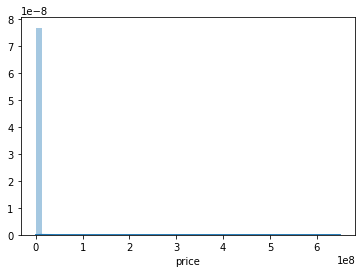

In [30]:
sns.distplot(df.price.loc[(~df.price.isnull())])

Como se puede apreciar en el gráfico, existen valores extremos, lo que le da la larga cola. Además, al estar trabajando con precios en pesos, las magnitudes se ven exageradas, por lo que trabajeremos con los precios en dólares.

A continuación dropeamos los precios que son irrelevantes, tales como 0, 1 y 11111

In [31]:
df.drop(df.loc[df.price_aprox_usd == df.price_aprox_usd.max()].index, axis=0, inplace=True)
df.drop(df.loc[df.price==0].index, axis=0, inplace=True)
df.drop(df.loc[(df.price==11111) | (df.price==111111) |\
               (df.price==1111111) | (df.price==11111111)].index, axis=0, inplace=True)

El siguiente gráfico es esencialmente el mismo que el anterior, pero en dólares, lo que permite apreciar el kernel ya que las magnitudes son menores.

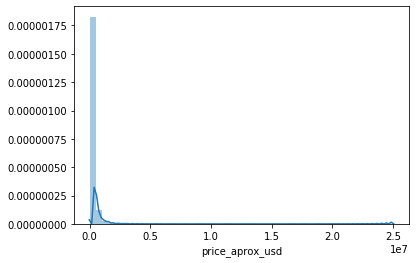

In [32]:
sns.distplot(df.price_aprox_usd.loc[(~df.price.isnull())])

Realizamos un boxplot para ver los outliers

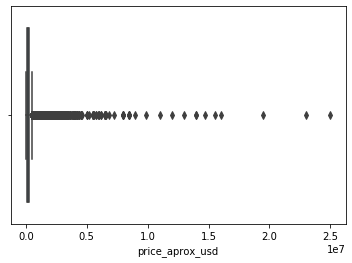

In [33]:
sns.boxplot(df.price_aprox_usd)

Tenemos algunos inmuebles con valores por encima de 10 millones de dólares, por lo que procedemos a revisarlos

In [35]:
df.loc[df.price_aprox_usd > 10000000].filter(['price_aprox_usd', 'lat', 'rooms', 'amb_tit'])

,price_aprox_usd,lat,rooms,amb_tit
525,11000000.00,NaN,NaN,NaN
34638,14000000.00,NaN,NaN,NaN
49083,15500000.00,NaN,NaN,NaN
84400,13000000.00,NaN,NaN,NaN
91229,14000000.00,NaN,NaN,NaN
91289,16000000.00,NaN,NaN,NaN
91428,14700000.00,NaN,NaN,NaN
91468,25000000.00,NaN,NaN,NaN
91479,19500000.00,NaN,NaN,NaN
107390,22980378.29,NaN,NaN,NaN


Aprovechamos el hecho de que les falta información de variables descriptivas para descartarlos y que son pocas observaciones

In [38]:
df.drop(df.loc[df.price_aprox_usd > 10000000].index, axis=0, inplace=True)

Ahora buscamos outliers en la variable `price_usd_per_m2`

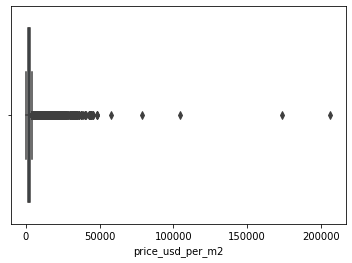

In [40]:
sns.boxplot(df.price_usd_per_m2)

Vemos que existen inmuebles con valores mayores a USD 50.000

In [42]:
df.columns

Index(['operation', 'property_type', 'place_name', 'country_name',
       'state_name', 'geonames_id', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail', 'pais', 'provincia', 'localidad', 'barrio', 'lat',
       'lon', 'amb_tit', 'dor_tit', 'bath_tit', 'amb_desc', 'dor_desc',
       'bath_desc', 'pozo', 'log_price', 'log_price_aprox_usd',
       'log_price_usd_per_m2'],
      dtype='object')

In [48]:
df.loc[df.price_usd_per_m2 > 40000].filter(['price_aprox_usd', 'localidad','lat', 'rooms', 'amb_tit','surface_total_in_m2'])

,price_aprox_usd,localidad,lat,rooms,amb_tit,surface_total_in_m2
25287,1643750.0,Rosario,-32.929490,1.0,NaN,41.0
25288,1643750.0,Rosario,-32.935143,2.0,NaN,37.0
25853,2356000.0,Boedo,NaN,1.0,NaN,30.0
25967,1150000.0,Rosario,-32.963188,1.0,NaN,27.0
26037,5214782.0,Boedo,NaN,1.0,NaN,30.0
26193,3657014.0,Boedo,NaN,1.0,NaN,35.0
26637,6809000.0,Boedo,-34.622204,1.0,NaN,33.0
26761,850000.0,Rosario,-32.957290,1.0,NaN,20.0
26905,1150000.0,Rosario,-32.949572,1.0,NaN,27.0
26992,2173330.0,General San Martín,NaN,2.0,NaN,45.0


Nuevamente, al ver que son tan pocas observaciones y en su mayoría tienen faltantes en variables descriptivas, optamos por descartarlos

In [49]:
df.drop(df.loc[df.price_usd_per_m2 > 40000].index, axis=0, inplace=True)

Realizamos un gráfico para ver la distribución de precios en dólares según tipo de inmueble

'PH en Azul, apartment en Naranja, house en Verde y store en Rojo'

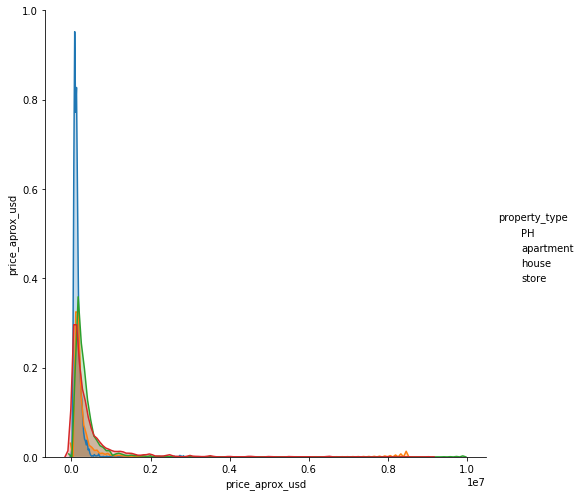

In [61]:
sns.pairplot(df, vars=['price_aprox_usd'], hue='property_type', height=7, markers='property_type'); 'PH en Azul, \
apartment en Naranja, house en Verde y store en Rojo'

Ahora realizamos el mismo gráfico pero sobre `log_price_aprox_usd`, para apreciar la transformación

'PH en Azul, apartment en Naranja, house en Verde y store en Rojo'

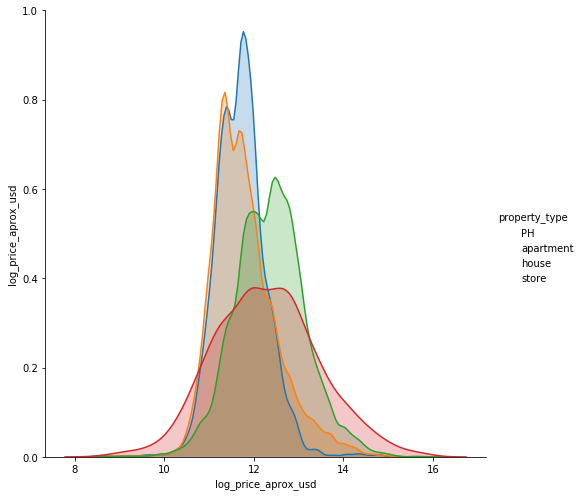

In [62]:
sns.pairplot(df, vars=['log_price_aprox_usd'], hue='property_type', height=7, markers='property_type' ); 'PH en Azul, \
apartment en Naranja, house en Verde y store en Rojo'

Y también sobre `price_usd_per_m2`y `log_price_usd_per_m2`

'PH en Azul, apartment en Naranja, house en Verde y store en Rojo'

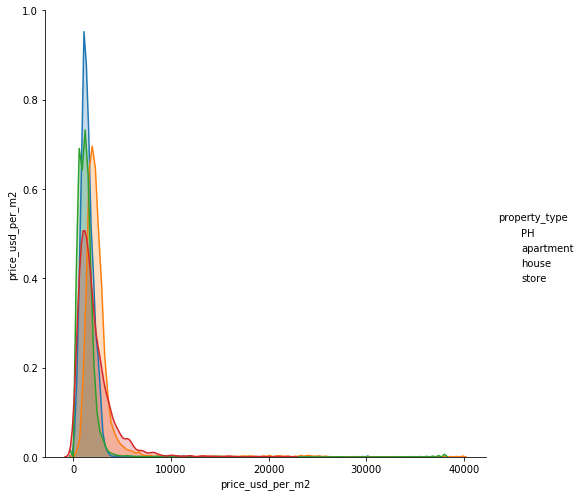

In [67]:
sns.pairplot(df, vars=['price_usd_per_m2'], hue='property_type', height=7, markers='property_type'); 'PH en Azul, \
apartment en Naranja, house en Verde y store en Rojo'

'PH en Azul, apartment en Naranja, house en Verde y store en Rojo'

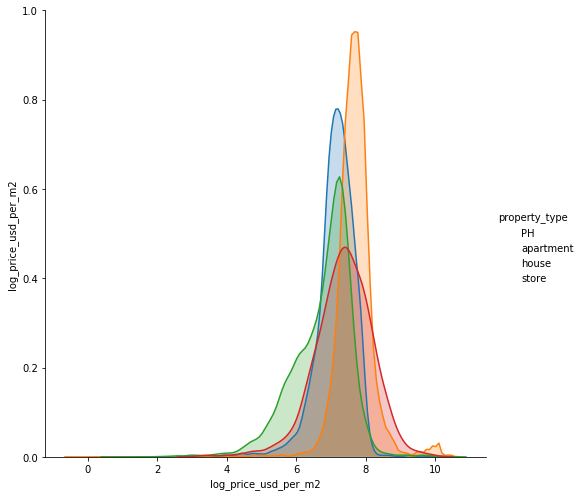

In [68]:
sns.pairplot(df, vars=['log_price_usd_per_m2'], hue='property_type', height=7, markers='property_type'); 'PH en Azul, \
apartment en Naranja, house en Verde y store en Rojo'

Nos concentramos en la Ciudad Autónoma de Buenos Aires para ver qué barrios tienen el valor por metro cuadrado más elevado según la mediana

In [72]:
caba = df.loc[(df.provincia== 'Capital Federal')].groupby('localidad').price_usd_per_m2.median().sort_values(ascending=False)
caba.index

Index(['Boedo', 'Puerto Madero', 'Las Cañitas', 'Recoleta', 'Palermo',
       'Belgrano', 'Nuñez', 'Barrio Norte', 'Retiro', 'San Cristobal',
       'Coghlan', 'Villa Urquiza', 'Colegiales', 'Villa Crespo', 'Caballito',
       'Saavedra', 'San Telmo', 'Villa Ortuzar', 'Parque Centenario',
       'Villa del Parque', 'Centro / Microcentro', 'San Nicolás', 'Agronomía',
       'Chacarita', 'Almagro', 'Villa Devoto', 'Abasto', 'Villa Luro',
       'Flores', 'Parque Chas', 'Villa Santa Rita', 'Monserrat', 'Tribunales',
       'Villa Pueyrredón', 'Monte Castro', 'Paternal', 'Congreso',
       'Villa General Mitre', 'Liniers', 'Balvanera', 'Barracas', 'Catalinas',
       'Parque Patricios', 'Once', 'Constitución', 'Floresta', 'Boca',
       'Parque Chacabuco', 'Versalles', '', 'Mataderos', 'Parque Avellaneda',
       'Villa Real', 'Velez Sarsfield', 'Villa Riachuelo', 'Villa Lugano',
       'Pompeya', 'Villa Soldati'],
      dtype='object', name='localidad')

Como podemos observar, el barrio de Boedo nos aparece en primer lugar, lo cual es llamativo

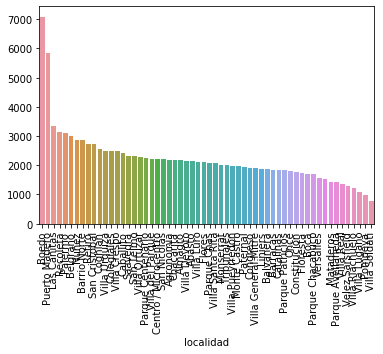

In [83]:
sns.barplot(a.index, a.values).set_xticklabels(labels=a.index, rotation=90);

Esto nos permite observar que existen outliers en el barrio de Boedo, por lo que procedemos a descartar dichos valores.

In [103]:
df.loc[(df.localidad =='Boedo') & (df.price_usd_per_m2 > a[1] )].sort_values('price_usd_per_m2', ascending=False).description.str.extract(r'(\bfinanc)|(\bcuota)', re.IGNORECASE, expand=True)

,0,1
25694,FINANC,NaN
25113,NaN,NaN
25012,financ,NaN
26028,NaN,CUOTA
26212,FINANC,NaN
...,...,...
25700,NaN,cuota
25696,NaN,cuota
25523,FINANC,NaN
25486,NaN,CUOTA


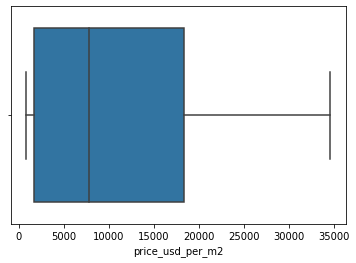

In [225]:
sns.boxplot(df.loc[df.localidad == 'Boedo'].price_usd_per_m2)

In [144]:
barrios = pd.read_csv('barrios.csv', encoding='latin1')
barrios.sample(10)

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
41,"POLYGON ((-58.3687995836552 -34.6068264253902,...",MONSERRAT,1.0,6739.222298,2.198622e+06
10,"POLYGON ((-58.4833907036583 -34.6241108718058,...",FLORESTA,10.0,7519.654092,2.320641e+06
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
5,"POLYGON ((-58.4306058283309 -34.6070470885963,...",CABALLITO,6.0,10990.964471,6.851029e+06
16,"POLYGON ((-58.4103697298525 -34.648302987509,-...",PARQUE PATRICIOS,4.0,7878.468115,3.743507e+06
28,"POLYGON ((-58.4605469510917 -34.5779429557773,...",VILLA ORTUZAR,15.0,5684.995211,1.853802e+06
21,"POLYGON ((-58.4724205132861 -34.5660977127668,...",COGHLAN,12.0,4627.563131,1.279951e+06
20,"POLYGON ((-58.4881310699952 -34.5612869279226,...",SAAVEDRA,12.0,11132.139346,5.538677e+06
43,"POLYGON ((-58.4515941108325 -34.5315273335599,...",BELGRANO,13.0,21504.197774,7.932303e+06
9,"POLYGON ((-58.4452515823782 -34.6420397134706,...",FLORES,7.0,15772.425185,8.590784e+06


In [146]:
def from_wkt(df, wkt_column):
    import shapely.wkt
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(barrios, geometry='coordinates')
    return gdf

In [147]:
barrios = from_wkt(barrios, "WKT")

In [148]:
df['localidad'] = df.localidad.str.upper()

In [85]:
#df2 = df.merge(barrios, how='left', left_on='localidad', right_on='BARRIO')

In [162]:
barrios_caba = df.loc[df.provincia == 'Capital Federal'].groupby('localidad')['price_usd_per_m2'].median()

In [163]:
barrios_caba.index

Index(['', 'ABASTO', 'AGRONOMÍA', 'ALMAGRO', 'BALVANERA', 'BARRACAS',
       'BARRIO NORTE', 'BELGRANO', 'BOCA', 'BOEDO', 'CABALLITO', 'CATALINAS',
       'CENTRO / MICROCENTRO', 'CHACARITA', 'COGHLAN', 'COLEGIALES',
       'CONGRESO', 'CONSTITUCIÓN', 'FLORES', 'FLORESTA', 'LAS CAÑITAS',
       'LINIERS', 'MATADEROS', 'MONSERRAT', 'MONTE CASTRO', 'NUÑEZ', 'ONCE',
       'PALERMO', 'PARQUE AVELLANEDA', 'PARQUE CENTENARIO', 'PARQUE CHACABUCO',
       'PARQUE CHAS', 'PARQUE PATRICIOS', 'PATERNAL', 'POMPEYA',
       'PUERTO MADERO', 'RECOLETA', 'RETIRO', 'SAAVEDRA', 'SAN CRISTOBAL',
       'SAN NICOLÁS', 'SAN TELMO', 'TRIBUNALES', 'VELEZ SARSFIELD',
       'VERSALLES', 'VILLA CRESPO', 'VILLA DEL PARQUE', 'VILLA DEVOTO',
       'VILLA GENERAL MITRE', 'VILLA LUGANO', 'VILLA LURO', 'VILLA ORTUZAR',
       'VILLA PUEYRREDÓN', 'VILLA REAL', 'VILLA RIACHUELO', 'VILLA SANTA RITA',
       'VILLA SOLDATI', 'VILLA URQUIZA'],
      dtype='object', name='localidad')

In [164]:
barrios_precios = barrios.merge(barrios_caba, how='left', left_on='BARRIO', right_on=barrios_caba.index.name)

E:\Miniconda3\envs\ds37\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


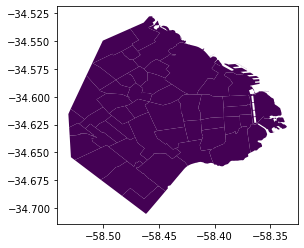

In [167]:
barrios_precios.plot('price_usd_per_m2')

E:\Miniconda3\envs\ds37\lib\site-packages\mapclassify\classifiers.py:276: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
E:\Miniconda3\envs\ds37\lib\site-packages\mapclassify\classifiers.py:276: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
E:\Miniconda3\envs\ds37\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


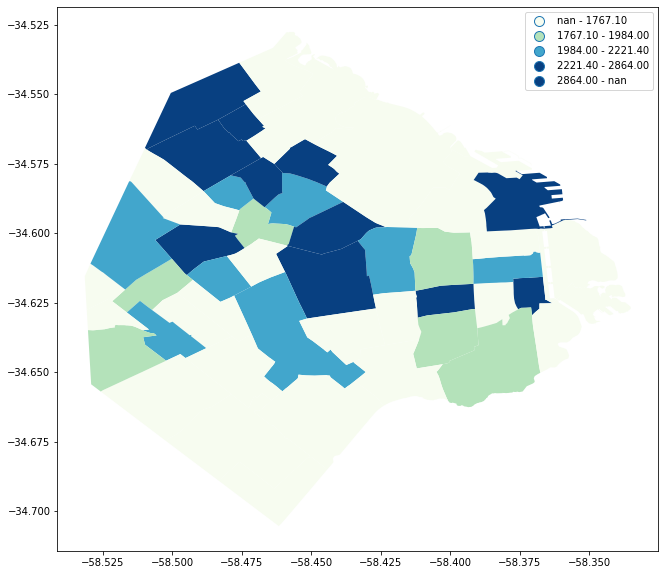

In [169]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))
barrios_precios.plot(column='price_usd_per_m2', scheme='Quantiles', 
        k=5, cmap='GnBu', legend=True, ax=ax)

In [105]:
df2['mediana'] = np.nan

In [108]:
df2 = df2.merge(barrios_caba, how='left', left_on='BARRIO', right_on=barrios_caba.index)
df2

,operation,property_type,place_name,country_name,state_name,geonames_id,price_x,currency,price_aprox_local_currency,price_aprox_usd,...,lprice_aprox_usd,lp_usd_m2,WKT,BARRIO,COMUNA,PERIMETRO,AREA,coordinates,mediana,price_y
0,sell,PH,Mataderos,Argentina,Capital Federal,3430787.0,62000.0,USD,1093959.00,62000.0,...,11.034890,7.027556,"POLYGON ((-58.5025197162337 -34.6745050265102,...",MATADEROS,9.0,11124.635792,7.398179e+06,"POLYGON ((-58.5025197162337 -34.6745050265102,...",NaN,135000.0
1,sell,apartment,La Plata,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,150000.0,USD,2646675.00,150000.0,...,11.918391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sell,apartment,Mataderos,Argentina,Capital Federal,3430787.0,72000.0,USD,1270404.00,72000.0,...,11.184421,7.177088,"POLYGON ((-58.5025197162337 -34.6745050265102,...",MATADEROS,9.0,11124.635792,7.398179e+06,"POLYGON ((-58.5025197162337 -34.6745050265102,...",NaN,135000.0
3,sell,PH,Liniers,Argentina,Capital Federal,3431333.0,95000.0,USD,1676227.50,95000.0,...,11.461632,NaN,"POLYGON ((-58.5192540532325 -34.6330100952683,...",LINIERS,9.0,9256.927321,4.374419e+06,"POLYGON ((-58.5192540532325 -34.6330100952683,...",NaN,125000.0
4,sell,apartment,Centro,Argentina,Buenos Aires Costa Atlántica,3435548.0,64000.0,USD,1129248.00,64000.0,...,11.066638,7.511290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119408,sell,apartment,Belgrano,Argentina,Capital Federal,3436077.0,870000.0,USD,15350715.00,870000.0,...,13.676248,8.948861,"POLYGON ((-58.4515941108325 -34.5315273335599,...",BELGRANO,13.0,21504.197774,7.932303e+06,"POLYGON ((-58.4515941108325 -34.5315273335599,...",NaN,219000.0
119409,sell,house,Beccar,Argentina,Bs.As. G.B.A. Zona Norte,3436080.0,498000.0,USD,8786961.00,498000.0,...,13.118355,7.232251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119410,sell,apartment,Villa Urquiza,Argentina,Capital Federal,3433775.0,131500.0,USD,2320251.75,131500.0,...,11.786762,7.958121,"POLYGON ((-58.4809767085347 -34.5626425900864,...",VILLA URQUIZA,12.0,10021.459665,5.449059e+06,"POLYGON ((-58.4809767085347 -34.5626425900864,...",NaN,150000.0
119411,sell,apartment,Plaza Colón,Argentina,Buenos Aires Costa Atlántica,NaN,95900.0,USD,1692107.55,95900.0,...,11.471061,7.599860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
df2.rename({'price_x':'price', 'price_y':'median_price'}, axis=1, inplace=True)

AttributeError: 'Series' object has no attribute 'xlabel'